# White Wine Quality Predictor

### Import Libraries

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200) 

from sklearn.preprocessing import QuantileTransformer
from scipy.stats import f_oneway, kruskal
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import make_scorer, f1_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from scipy.stats import randint
from sklearn.model_selection import StratifiedKFold, cross_val_score

import os
import joblib

### Data Cleaning & Preprocessing

In [7]:
df_white = pd.read_csv('../Data/winequality-white.csv', sep=';', header=0)
df_white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [8]:
df_white.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [9]:
df_white.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,4898.0,6.854788,0.843868,3.80000,6.300000,6.80000,7.3000,14.20000
volatile acidity,4898.0,0.278241,0.100795,0.08000,0.210000,0.26000,0.3200,1.10000
citric acid,4898.0,0.334192,0.121020,0.00000,0.270000,0.32000,0.3900,1.66000
residual sugar,4898.0,6.391415,5.072058,0.60000,1.700000,5.20000,9.9000,65.80000
chlorides,4898.0,0.045772,0.021848,0.00900,0.036000,0.04300,0.0500,0.34600
free sulfur dioxide,4898.0,35.308085,17.007137,2.00000,23.000000,34.00000,46.0000,289.00000
total sulfur dioxide,4898.0,138.360657,42.498065,9.00000,108.000000,134.00000,167.0000,440.00000
density,4898.0,0.994027,0.002991,0.98711,0.991723,0.99374,0.9961,1.03898
pH,4898.0,3.188267,0.151001,2.72000,3.090000,3.18000,3.2800,3.82000
sulphates,4898.0,0.489847,0.114126,0.22000,0.410000,0.47000,0.5500,1.08000


In [10]:
# Rename columns

df_white.rename(columns={
    'fixed acidity': 'fixed_acidity',
    'volatile acidity': 'volatile_acidity',
    'citric acid': 'citric_acid',
    'residual sugar': 'residual_sugar',
    'free sulfur dioxide': 'free_sulfur_dioxide',
    'total sulfur dioxide': 'total_sulfur_dioxide'
}, inplace=True)

In [11]:
df_white.isna().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [12]:
df_white.duplicated().sum()

937

In [13]:
# drop duplicates
df_white = df_white.drop_duplicates().reset_index(drop=True)

## EDA

In [14]:
df_white['quality'].value_counts()

6    1788
5    1175
7     689
4     153
8     131
3      20
9       5
Name: quality, dtype: int64

* In this step, we will create a new feature called quality_label to categorize the quality rankings of wine (from 3 to 9) into three groups: low, medium, and high. 
* It will be as follows:

    * Scores of 3, 4 will be labeled as 0 (low quality).
    * Scores of 5,6,7 will be labeled as 1 (medium quality).
    * Scores of 8,9 will be labeled as 2 (high quality).

* This categorization will help improve the model's performance by simplifying the target variable.

In [15]:
df_white['quality_label'] = df_white['quality'].apply(
    lambda x: 0 if x <= 4 else (1 if 5 <= x <= 7 else 2)
)
df_white['quality_label'].value_counts()

1    3652
0     173
2     136
Name: quality_label, dtype: int64

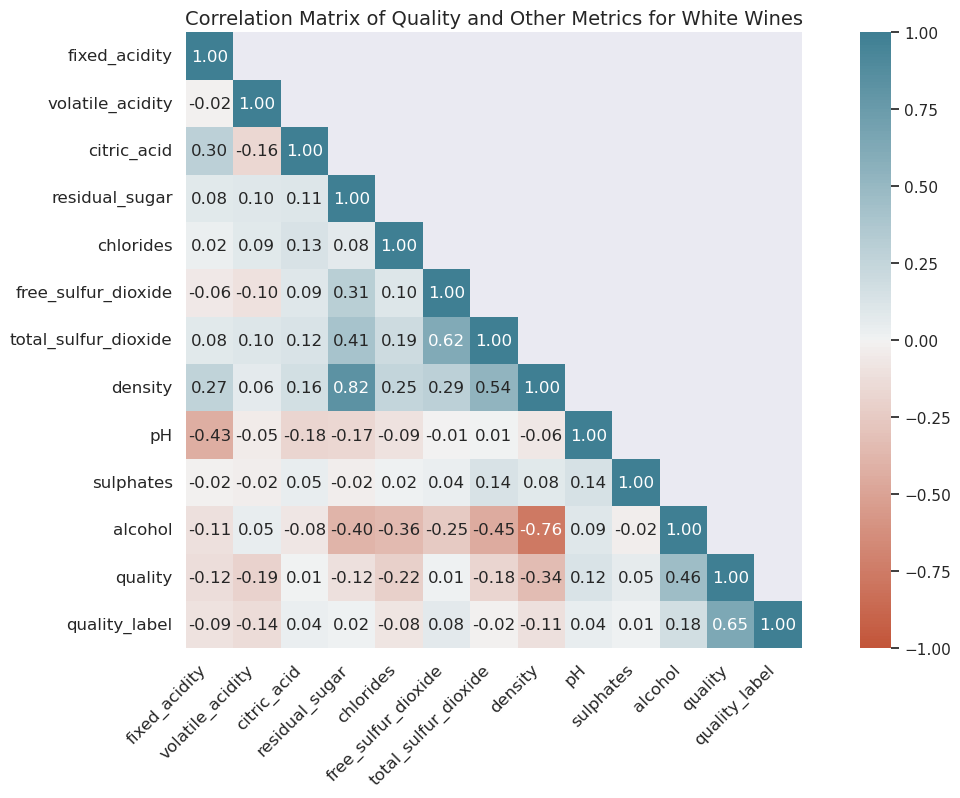

In [16]:
# create a heatmap to check relation between quality and other features

# Compute the correlation matrix

corr = df_white.corr(numeric_only=True)

# Create a mask for the upper triangle

mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Set the figure size and plot the heatmap with the mask

sns.set_theme(rc={'figure.figsize': (15, 8)})
ax = sns.heatmap(corr, mask=mask, annot=True, vmin=-1, vmax=1, fmt='.2f', cmap=sns.diverging_palette(20, 220, n=200), square=True)

# Customize the tick labels and title

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Correlation Matrix of Quality and Other Metrics for White Wines', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [17]:
df_white.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'quality_label'],
      dtype='object')

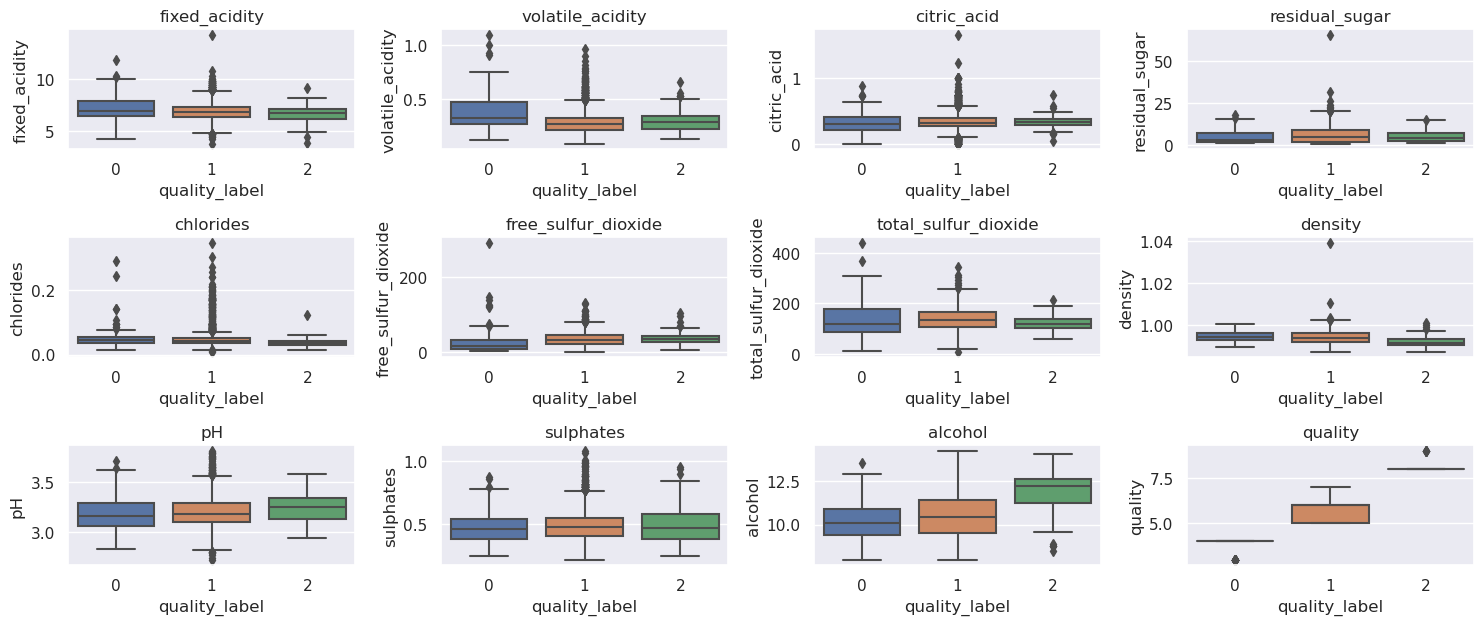

In [18]:
# Plot distribution of each feature grouped by quality score

# define features
features = df_white[['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality']]
# plot
plt.figure(figsize=(15, 8))
for i, col in enumerate(features, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(x='quality_label', y=col, data=df_white)
    plt.title(f'{col}')
plt.tight_layout()
plt.show()

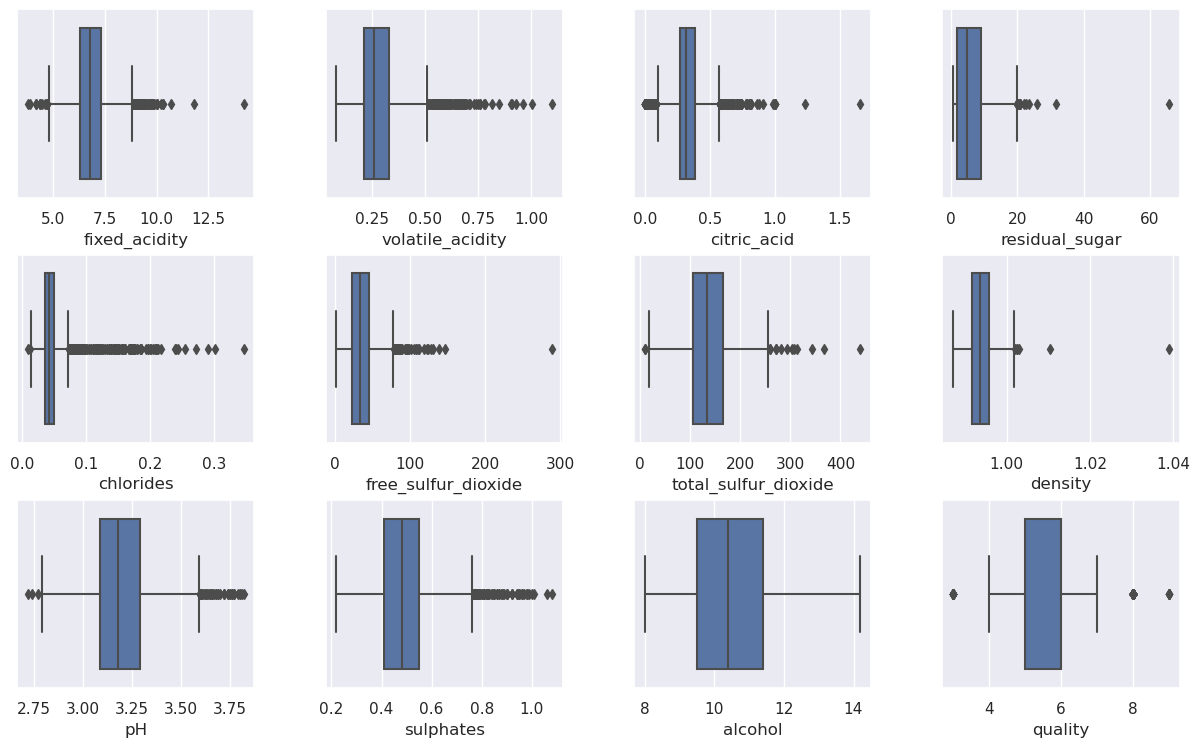

In [19]:
# Check outliers
plt.figure(figsize=(15, 12))

for i, feature in enumerate(features, 1):
    plt.subplot(4, 4, i)  # 3 rows, 4 columns, plot by index
    sns.boxplot(x=df_white[feature])
    
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.show()

In [20]:
df_white.skew()

fixed_acidity           0.696100
volatile_acidity        1.641081
citric_acid             1.310601
residual_sugar          1.333639
chlorides               4.969076
free_sulfur_dioxide     1.566680
total_sulfur_dioxide    0.456800
density                 1.273318
pH                      0.455457
sulphates               0.937853
alcohol                 0.450697
quality                 0.112004
quality_label          -0.329132
dtype: float64

In [21]:
df_white.kurtosis()

fixed_acidity            2.253047
volatile_acidity         5.327754
citric_acid              6.844808
residual_sugar           5.681512
chlorides               35.530288
free_sulfur_dioxide     13.434025
total_sulfur_dioxide     0.735258
density                 14.184892
pH                       0.549957
sulphates                1.565021
alcohol                 -0.695980
quality                  0.299345
quality_label            9.810630
dtype: float64

* Outliers are present in the features: chlorides, volatile_acidity, citric_acid, residual_sugar, free_sulfur_dioxide, and density.

In [22]:
def remove_extremes(df, columns, lower_q=0.01, upper_q=0.99):
    for col in columns:
        lower = df[col].quantile(lower_q)
        upper = df[col].quantile(upper_q)
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

df_white_ml = remove_extremes(df_white, ['chlorides', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'free_sulfur_dioxide', 'density'])
df_white_ml.shape


(3570, 13)

In [23]:
df_white_ml.skew()

fixed_acidity           0.731740
volatile_acidity        0.990332
citric_acid             0.924225
residual_sugar          0.770665
chlorides               3.292126
free_sulfur_dioxide     0.401462
total_sulfur_dioxide    0.365016
density                 0.269803
pH                      0.446810
sulphates               0.923313
alcohol                 0.415738
quality                 0.196953
quality_label           0.062792
dtype: float64

In [24]:
df_white_ml.kurtosis()

fixed_acidity            2.495472
volatile_acidity         1.395687
citric_acid              1.836237
residual_sugar          -0.451474
chlorides               17.911153
free_sulfur_dioxide     -0.394075
total_sulfur_dioxide    -0.141057
density                 -0.791109
pH                       0.584535
sulphates                1.591376
alcohol                 -0.731311
quality                  0.200558
quality_label           11.708757
dtype: float64

In [25]:
df_white_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3570 entries, 1 to 3958
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         3570 non-null   float64
 1   volatile_acidity      3570 non-null   float64
 2   citric_acid           3570 non-null   float64
 3   residual_sugar        3570 non-null   float64
 4   chlorides             3570 non-null   float64
 5   free_sulfur_dioxide   3570 non-null   float64
 6   total_sulfur_dioxide  3570 non-null   float64
 7   density               3570 non-null   float64
 8   pH                    3570 non-null   float64
 9   sulphates             3570 non-null   float64
 10  alcohol               3570 non-null   float64
 11  quality               3570 non-null   int64  
 12  quality_label         3570 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 390.5 KB


In [26]:
df_white.shape

(3961, 13)

*  About 27% of the records have been removed(4898 to 3570) after dropping duplicates and outliers. 

### Feature Selection & Hypothesis Testing

In [27]:
# Apply ANOVA for features
anova_results = {}
for feature in ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol']:
    groups = [df_white_ml[df_white_ml['quality_label'] == label][feature] for label in df_white_ml['quality_label'].unique()]
    anova_results[feature] = f_oneway(*groups)

for feature, result in anova_results.items():
    print(f'{feature}: F-statistic = {result.statistic:.3f}, p-value = {result.pvalue:.3f}')

fixed_acidity: F-statistic = 14.151, p-value = 0.000
volatile_acidity: F-statistic = 26.140, p-value = 0.000
citric_acid: F-statistic = 0.588, p-value = 0.555
residual_sugar: F-statistic = 2.965, p-value = 0.052
chlorides: F-statistic = 22.812, p-value = 0.000
free_sulfur_dioxide: F-statistic = 30.046, p-value = 0.000
total_sulfur_dioxide: F-statistic = 11.954, p-value = 0.000
density: F-statistic = 40.463, p-value = 0.000
pH: F-statistic = 4.857, p-value = 0.008
sulphates: F-statistic = 0.418, p-value = 0.658
alcohol: F-statistic = 87.832, p-value = 0.000


* Selected features based on F-test p-values and results are listed below:

'fixed_acidity', 'volatile_acidity',  'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'alcohol'

In [28]:
# Define features and target(features are selected based on F-test p-values and results of the models)
selected_features = ['fixed_acidity', 'volatile_acidity',  'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'alcohol', 'quality', 'quality_label']

df_white_ml = df_white_ml[selected_features]
df_white_ml.head()

,fixed_acidity,volatile_acidity,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,alcohol,quality,quality_label
1,6.3,0.30,0.049,14.0,132.0,9.5,6,1
2,8.1,0.28,0.050,30.0,97.0,10.1,6,1
3,7.2,0.23,0.058,47.0,186.0,9.9,6,1
4,6.2,0.32,0.045,30.0,136.0,9.6,6,1
5,8.1,0.22,0.044,28.0,129.0,11.0,6,1


In [29]:
# Rename columns
rename_columns = {
    'fixed_acidity': 'FA',
    'volatile_acidity': 'VA',
    'chlorides': 'Cl',
    'free_sulfur_dioxide': 'FSO2',
    'total_sulfur_dioxide': 'TSO2',
    'alcohol': 'Alc',
    'quality': 'Q.Score',
    'quality_label': 'Quality'
}

# Apply 
df_white_ml = df_white_ml.rename(columns=rename_columns)

# Reorder columns
df_white_ml = df_white_ml[['Quality', 'Q.Score', 'Alc', 'Cl', 'TSO2', 'VA', 'FSO2' , 'FA']]

df_white_ml.head()

,Quality,Q.Score,Alc,Cl,TSO2,VA,FSO2,FA
1,1,6,9.5,0.049,132.0,0.30,14.0,6.3
2,1,6,10.1,0.050,97.0,0.28,30.0,8.1
3,1,6,9.9,0.058,186.0,0.23,47.0,7.2
4,1,6,9.6,0.045,136.0,0.32,30.0,6.2
5,1,6,11.0,0.044,129.0,0.22,28.0,8.1


In [30]:
# view the count of classes
df_white_ml['Quality'].value_counts()

1    3327
2     124
0     119
Name: Quality, dtype: int64

* Mid-quality wine significantly dominates the dataset. To address this class imbalance and improve the model's prediction for minor classes (low and high ), SMOTE will be applied on the training data.

In [31]:
df_white_ml.describe()

,Quality,Q.Score,Alc,Cl,TSO2,VA,FSO2,FA
count,3570.000000,3570.000000,3570.000000,3570.000000,3570.000000,3570.000000,3570.000000,3570.000000
mean,1.001401,5.885434,10.589159,0.044496,137.413585,0.273986,34.551261,6.846849
std,0.260930,0.865927,1.179575,0.015814,40.705198,0.089031,15.273569,0.840576
min,0.000000,3.000000,8.000000,0.020000,24.000000,0.120000,6.000000,3.900000
25%,1.000000,5.000000,9.600000,0.036000,107.250000,0.210000,23.000000,6.300000
50%,1.000000,6.000000,10.500000,0.043000,133.000000,0.260000,33.000000,6.800000
75%,1.000000,6.000000,11.400000,0.050000,166.000000,0.320000,45.000000,7.300000
max,2.000000,9.000000,14.000000,0.168000,344.000000,0.640000,81.000000,14.200000


### Train-Test Split & Balance Data 

In [32]:
# Define features and target(features are selected based on F-test p-values and results of the models)
selected_features = ['Alc', 'Cl',  'TSO2', 'VA', 'FSO2', 'FA']

X = df_white_ml[selected_features]
y = df_white_ml['Quality']

# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print('Original class distribution in training set:')
print(y_train.value_counts())

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print('\nClass distribution after SMOTE:')
print(y_train_smote.value_counts())

Original class distribution in training set:
1    2662
2      99
0      95
Name: Quality, dtype: int64

Class distribution after SMOTE:
1    2662
2    2662
0    2662
Name: Quality, dtype: int64


## Model Evaluation & Selection

### Decision Trees

In [33]:
# Train Decision Tree on SMOTE data 
dt_model = DecisionTreeClassifier(random_state=42, max_depth=4, class_weight='balanced')
dt_model.fit(X_train_smote, y_train_smote)

# Predict on test data
y_pred_dt = dt_model.predict(X_test)

# Evaluate
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print('Accuracy of Decision Tree:', accuracy_dt)

print('\nClassification Report for Decision Tree:')
print(classification_report(y_test, y_pred_dt, zero_division=0))

print('\nConfusion Matrix for Decision Tree:')
print(confusion_matrix(y_test, y_pred_dt))

Accuracy of Decision Tree: 0.41596638655462187

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.09      0.62      0.16        24
           1       0.97      0.39      0.56       665
           2       0.07      0.84      0.14        25

    accuracy                           0.42       714
   macro avg       0.38      0.62      0.29       714
weighted avg       0.91      0.42      0.53       714


Confusion Matrix for Decision Tree:
[[ 15   7   2]
 [141 261 263]
 [  2   2  21]]


### Random Forest

In [34]:
# Initialize the Random Forest Classifier 
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Fit the model to training data 
rf_model.fit(X_train_smote, y_train_smote)  

# Predict on the test data 
y_pred_rf = rf_model.predict(X_test)  

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print('Accuracy of Random Forest:', accuracy_rf)

# Classification Report for Random Forest
print('\nClassification Report for Random Forest:')
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix for Random Forest
print('\nConfusion Matrix for Random Forest:')
print(confusion_matrix(y_test, y_pred_rf))


Accuracy of Random Forest: 0.8683473389355743

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.22      0.25      0.24        24
           1       0.94      0.92      0.93       665
           2       0.12      0.20      0.15        25

    accuracy                           0.87       714
   macro avg       0.43      0.46      0.44       714
weighted avg       0.89      0.87      0.88       714


Confusion Matrix for Random Forest:
[[  6  18   0]
 [ 21 609  35]
 [  0  20   5]]


### Gradient Boosting

In [35]:
# Initialize and fit the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Fit on original training data 
gb_model.fit(X_train_smote, y_train_smote)

# Predict on test data
y_pred_gb = gb_model.predict(X_test)

# Evaluate
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print('\nAccuracy of Gradient Boosting:', accuracy_gb)

print('\nClassification Report for Gradient Boosting:')
print(classification_report(y_test, y_pred_gb, zero_division=0))

print('\nConfusion Matrix for Gradient Boosting:')
print(confusion_matrix(y_test, y_pred_gb))


Accuracy of Gradient Boosting: 0.8067226890756303

Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.17      0.42      0.24        24
           1       0.95      0.84      0.89       665
           2       0.13      0.36      0.19        25

    accuracy                           0.81       714
   macro avg       0.42      0.54      0.44       714
weighted avg       0.89      0.81      0.84       714


Confusion Matrix for Gradient Boosting:
[[ 10  14   0]
 [ 48 557  60]
 [  0  16   9]]


### Logistic Regression

In [36]:
# Initialize and fit Logistic Regression model
logreg = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
logreg.fit(X_train_smote, y_train_smote)

# Predict on test data
y_pred_logreg = logreg.predict(X_test)

# Evaluate
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print('\nAccuracy of Logistic Regression:', accuracy_logreg)

print('\nClassification Report for Logistic Regression:')
print(classification_report(y_test, y_pred_logreg, zero_division=0))

print('\nConfusion Matrix for Logistic Regression:')
print(confusion_matrix(y_test, y_pred_logreg))


Accuracy of Logistic Regression: 0.5182072829131653

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.08      0.54      0.14        24
           1       0.96      0.51      0.66       665
           2       0.10      0.76      0.17        25

    accuracy                           0.52       714
   macro avg       0.38      0.60      0.32       714
weighted avg       0.90      0.52      0.63       714


Confusion Matrix for Logistic Regression:
[[ 13   9   2]
 [150 338 177]
 [  0   6  19]]


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### SVM

In [37]:
# Initialize and fit SVM model
svm_model = SVC(random_state=42, class_weight='balanced')
svm_model.fit(X_train_smote, y_train_smote)

# Predict on test data
y_pred_svm = svm_model.predict(X_test)

# Evaluate
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print('\nAccuracy of SVM:', accuracy_svm)

print('\nClassification Report for SVM:')
print(classification_report(y_test, y_pred_svm, zero_division=0))

print('\nConfusion Matrix for SVM:')
print(confusion_matrix(y_test, y_pred_svm))


Accuracy of SVM: 0.35014005602240894

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.09      0.67      0.16        24
           1       0.95      0.32      0.48       665
           2       0.06      0.76      0.11        25

    accuracy                           0.35       714
   macro avg       0.37      0.58      0.25       714
weighted avg       0.89      0.35      0.46       714


Confusion Matrix for SVM:
[[ 16   8   0]
 [161 215 289]
 [  3   3  19]]


### AdaBoost

In [38]:
# Initialize and fit AdaBoost model
ada_model = AdaBoostClassifier(random_state=42)
ada_model.fit(X_train_smote, y_train_smote)

# Predict on test data
y_pred_ada = ada_model.predict(X_test)

# Evaluate
accuracy_ada = accuracy_score(y_test, y_pred_ada)
print('\nAccuracy of AdaBoost:', accuracy_ada)

print('\nClassification Report for AdaBoost:')
print(classification_report(y_test, y_pred_ada, zero_division=0))

print('\nConfusion Matrix for AdaBoost:')
print(confusion_matrix(y_test, y_pred_ada))


Accuracy of AdaBoost: 0.4887955182072829

Classification Report for AdaBoost:
              precision    recall  f1-score   support

           0       0.10      0.71      0.17        24
           1       0.97      0.47      0.63       665
           2       0.09      0.76      0.16        25

    accuracy                           0.49       714
   macro avg       0.38      0.65      0.32       714
weighted avg       0.91      0.49      0.60       714


Confusion Matrix for AdaBoost:
[[ 17   5   2]
 [154 313 198]
 [  0   6  19]]


### Model Selection and Hyperparameter Tuning

* Random Forest has the highest overall accuracy and perform well to predict medium-quality wines.
* However, the high accuracy is misleading, as it is largely driven by the dominant medium class, and model fails to predict the minority classes (low and high quality)
* The Decision Tree model, despite its lower overall accuracy, shows better results for minority classes, making it more effective when the goal is to detect those categories.

* In this case I am adopting a hybrid approach:

        Use Random Forest for medium quality wines.

        Use Decision Tree to improve detection of low and high quality wines.

        This hybrid approach reduces the risk of mislabeling low/high-quality wines as medium, which is common in imbalanced datasets.
        Some medium-quality wines may be classified as low or high due to Decision Tree fallback, but I accept that since my aim is not to miss high and low quality wines.

### Hyperparameter Tuning & Cross Validation 

In [39]:
# Parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': ['balanced', None]
}

# Initialize model
rf_model = RandomForestClassifier(random_state=42)

# RandomizedSearchCV setup
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid_rf,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit on SMOTE data
random_search_rf.fit(X_train_smote, y_train_smote)

# Best model
best_rf_model = random_search_rf.best_estimator_
print('Best Parameters for Random Forest:', random_search_rf.best_params_)

# Evaluate on test data
y_pred_rf = best_rf_model.predict(X_test)

print('\nAccuracy of Tuned Random Forest:', accuracy_score(y_test, y_pred_rf))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_rf, zero_division=0))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_rf))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END class_weight=None, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.7s
[CV] END class_weight=None, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.7s
[CV] END class_weight=None, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.7s


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=None, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.7s
[CV] END class_weight=None, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.8s
[CV] END class_weight=None, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   4.4s
[CV] END class_weight=None, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   4.4s
[CV] END class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.0s
[CV] END class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.1s
[CV] END class_weight=None, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   4.6s
[CV] END clas

/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.7s


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   9.1s


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   8.5s


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   9.1s


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   9.1s
[CV] END class_weight=None, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   9.2s


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=None, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   8.5s
[CV] END class_weight=None, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   3.2s
[CV] END class_weight=None, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   3.5s


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=None, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   8.6s
[CV] END class_weight=None, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   8.7s
[CV] END class_weight=None, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   3.5s
[CV] END class_weight=None, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   3.3s
[CV] END class_weight=None, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   3.4s
[CV] END class_weight=None, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   8.9s
[CV] END class_weight=None, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   8.4s
[CV] END class_weight=No

/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=None, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 2.6min
[CV] END class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.7s


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   3.4s


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=balanced, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   3.8s


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=balanced, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.9s


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=balanced, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.8s


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   3.7s


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=balanced, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.8s


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=balanced, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   4.0s
[CV] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   4.1s
[CV] END class_weight=balanced, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   3.6s
[CV] END class_weight=balanced, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   3.9s
[CV] END class_weight=balanced, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   3.4s
[CV] END class_weight=balanced, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   

/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.6s


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=None, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.7s


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=None, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   3.3s
[CV] END class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.1s


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.3s
[CV] END class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.5s
[CV] END class_weight=None, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   3.2s
[CV] END class_weight=None, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   3.3s
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.7s
[CV] END class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.5s
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.6s
[

/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.6s


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.4s
[CV] END class_weight=balanced, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.4s


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.7s


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END class_weight=balanced, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.9s
[CV] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.9s
[CV] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.8s
[CV] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.6s
[CV] END cl

/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=None, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END class_weight=None, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.3s


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   8.2s
[CV] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   8.2s
[CV] END class_weight=None, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.3s


/home/airsahin/miniconda3/envs/wine-modeling/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   3.2s
[CV] END class_weight=None, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   3.2s
[CV] END class_weight=None, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   7.9s
[CV] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   7.9s
Best Parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_

In [40]:
# Parameter grid for Decision Tree
param_grid_dt = {
    'max_depth': [3, 4, 5, 6, 7, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'class_weight': ['balanced', None]
}

# Initialize model
dt_model = DecisionTreeClassifier(random_state=42)

# Setup RandomizedSearchCV
random_search_dt = RandomizedSearchCV(
    estimator=dt_model,
    param_distributions=param_grid_dt,
    n_iter=20,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit on SMOTE data
random_search_dt.fit(X_train_smote, y_train_smote)

# Best model
best_dt_model = random_search_dt.best_estimator_
print('Best Parameters for Decision Tree:', random_search_dt.best_params_)

# Predict on test data
y_pred_dt = best_dt_model.predict(X_test)

# Evaluate
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print('\nAccuracy of Tuned Decision Tree:', accuracy_dt)

print('\nClassification Report for Tuned Decision Tree:')
print(classification_report(y_test, y_pred_dt, zero_division=0))

print('\nConfusion Matrix for Tuned Decision Tree:')
print(confusion_matrix(y_test, y_pred_dt))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV] END class_weight=None, max_depth=5, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, max_depth=5, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, max_depth=5, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, max_depth=5, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END 

* Tuning slightly improved overall metrics like accuracy but doesn't fix imbalanced class detection problems and tuned versions don’t improve recall/precision.
* Therefore, untuned models are preferred in the hybrid approach to better balance class-specific performance.

In [41]:
df_white_ml.head()

,Quality,Q.Score,Alc,Cl,TSO2,VA,FSO2,FA
1,1,6,9.5,0.049,132.0,0.30,14.0,6.3
2,1,6,10.1,0.050,97.0,0.28,30.0,8.1
3,1,6,9.9,0.058,186.0,0.23,47.0,7.2
4,1,6,9.6,0.045,136.0,0.32,30.0,6.2
5,1,6,11.0,0.044,129.0,0.22,28.0,8.1


In [42]:
# Sample 30 records to show on app as example

df_low = df_white_ml[df_white_ml['Quality'] == 0].sample(n=3, random_state=43)
df_medium = df_white_ml[df_white_ml['Quality'] == 1].sample(n=3, random_state=43)
df_high = df_white_ml[df_white_ml['Quality'] == 2].sample(n=4, random_state=43)

# Combine without shuffle since we're sorting next
df_white_sample = pd.concat([df_low, df_medium, df_high])

# Define mapping 
quality_map = {
    0: 'Low',
    1: 'Medium',
    2: 'High'
}

df_white_sample['Quality'] = df_white_sample['Quality'].map(quality_map)

# Sort by Q.Score for display
df_white_sample = df_white_sample.sort_values(by='Q.Score').reset_index(drop=True)

df_white_sample.head(10)


,Quality,Q.Score,Alc,Cl,TSO2,VA,FSO2,FA
0,Low,4,10.4,0.042,61.0,0.350,15.0,9.2
1,Low,4,9.8,0.034,148.0,0.350,9.0,6.4
2,Low,4,12.9,0.030,76.0,0.640,18.0,6.7
3,Medium,5,11.5,0.028,93.0,0.210,20.0,8.9
4,Medium,6,12.3,0.033,74.0,0.335,17.0,5.2
5,Medium,6,10.7,0.030,144.0,0.160,29.0,6.1
6,High,8,12.4,0.045,95.0,0.210,38.0,5.8
7,High,8,12.6,0.030,92.0,0.260,36.0,6.5
8,High,8,10.4,0.121,162.0,0.170,32.0,7.3
9,High,8,12.9,0.026,126.0,0.250,54.0,6.0


In [43]:
# Initialize the Random Forest Classifier 
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Fit the model to training data 
rf_model.fit(X_train_smote, y_train_smote)  

# Predict on the test data 
y_pred_rf = rf_model.predict(X_test)  

In [44]:
# Train Decision Tree on SMOTE data 
dt_model = DecisionTreeClassifier(random_state=42, max_depth=4, class_weight='balanced')
dt_model.fit(X_train_smote, y_train_smote)

# Predict on test data
y_pred_dt = dt_model.predict(X_test)

In [46]:
# define folders to save sample and clean dataset
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
data_dir = os.path.join(project_root, 'Data')

In [47]:
df_white_ml.to_csv(os.path.join(data_dir, 'winequality_clean.csv'), index=False)
df_white_sample.to_csv(os.path.join(data_dir, 'sample.csv'), index=False)

In [48]:
df_white_ml

,Quality,Q.Score,Alc,Cl,TSO2,VA,FSO2,FA
1,1,6,9.5,0.049,132.0,0.30,14.0,6.3
2,1,6,10.1,0.050,97.0,0.28,30.0,8.1
3,1,6,9.9,0.058,186.0,0.23,47.0,7.2
4,1,6,9.6,0.045,136.0,0.32,30.0,6.2
5,1,6,11.0,0.044,129.0,0.22,28.0,8.1
...,...,...,...,...,...,...,...,...
3954,1,6,10.6,0.038,121.0,0.21,38.0,5.7
3955,1,5,9.7,0.032,112.0,0.23,29.0,6.5
3956,1,6,11.2,0.039,92.0,0.21,24.0,6.2
3957,1,5,9.6,0.047,168.0,0.32,57.0,6.6


### Feature Importances – Random Forest

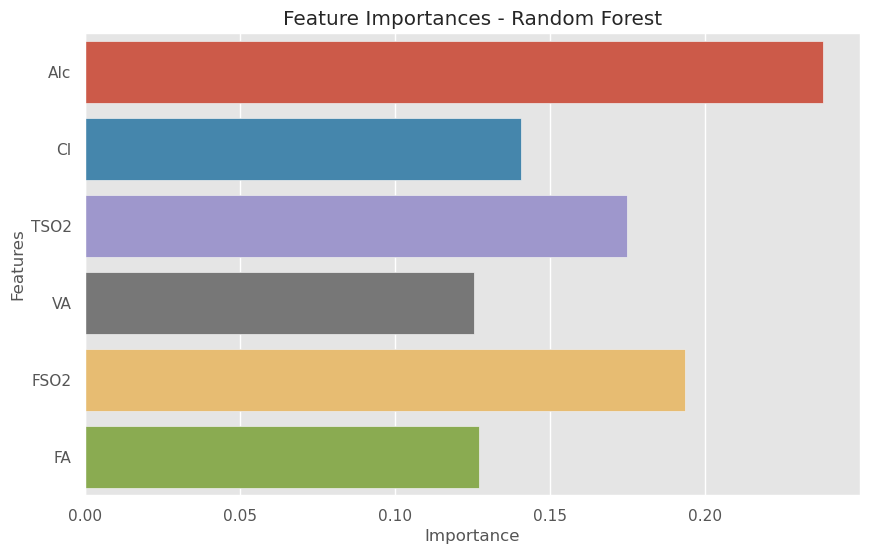

In [49]:
# Get feature importances
importances_rf = rf_model.feature_importances_
features = X_train.columns

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances_rf, y=features)
plt.title('Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

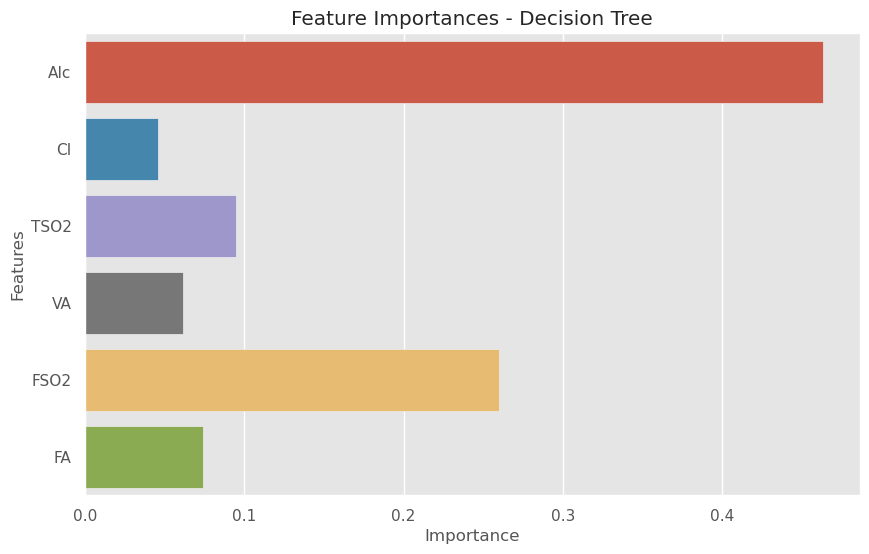

In [50]:
# Get feature importances
importances_dt = dt_model.feature_importances_

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances_dt, y=features)
plt.title('Feature Importances - Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


### Save Model for Streamlit App

In [55]:
# define path to save models
models_dir = os.path.join(project_root, 'model')

In [56]:
# Save models to model folder
joblib.dump(rf_model, os.path.join(models_dir, 'wine_quality_rf_model.pkl'))
joblib.dump(dt_model, os.path.join(models_dir, 'wine_quality_dt_model.pkl'))

print('saved')

saved
